### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
from qcodes.instrument_drivers.AlazarTech.acq_controllers import ATS9360Controller
from qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_channel import AlazarChannel
import qcodes.instrument_drivers.AlazarTech.acq_helpers as helpers
from qcodes.station import Station

import logging
logging.basicConfig(level=logging.INFO)

User schema at C:\Users\Jens/qcodesrc_schema.json not found.User settings won't be validated


In [3]:
from qcodes.instrument.parameter import ManualParameter
import qcodes

NB: See ATS9360 example notebook for general commands 

In [4]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '6.0.0',
 'asopc_type': '1779729248',
 'bits_per_sample': 12,
 'driver_version': '6.0.0',
 'firmware': None,
 'latest_cal_date': '25-01-17',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970396',
 'vendor': 'AlazarTech'}

In [5]:
# Configure all settings in the Alazar card
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=1_000_000_000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

## Example 1

Pulls the raw data the alazar acquires averaged over records and buffers.

In [6]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to. Explicitly pass the default options to the Alazar.
# Dont integrate over samples but avarage over records
myctrl = ATS9360Controller(name='my_controller', alazar_name='Alazar')

Put the Alazar and the controller in a station so we ensure that all parameters are captured

In [7]:
station = qc.Station(alazar, myctrl)

INFO:root:Snapshot: Could not update parameter: mode
INFO:root:Snapshot: Could not update parameter: samples_per_record
INFO:root:Snapshot: Could not update parameter: records_per_buffer
INFO:root:Snapshot: Could not update parameter: buffers_per_acquisition
INFO:root:Snapshot: Could not update parameter: channel_selection
INFO:root:Snapshot: Could not update parameter: transfer_offset
INFO:root:Snapshot: Could not update parameter: external_startcapture
INFO:root:Snapshot: Could not update parameter: enable_record_headers
INFO:root:Snapshot: Could not update parameter: alloc_buffers
INFO:root:Snapshot: Could not update parameter: fifo_only_streaming
INFO:root:Snapshot: Could not update parameter: interleave_samples
INFO:root:Snapshot: Could not update parameter: get_processed_data
INFO:root:Snapshot: Could not update parameter: allocated_buffers
INFO:root:Snapshot: Could not update parameter: buffer_timeout


This controller is designed to be highlevel and it is not possible to directly set number of records, buffers and samples. The number of samples is indirecly controlled by the integration time and integration delay and the number of averages controls the number of buffers and records acquired

In [8]:
myctrl.int_time.set?

In [9]:
myctrl.int_time._latest

{'raw_value': None,
 'ts': datetime.datetime(2017, 11, 3, 15, 33, 15, 479504),
 'value': None}

In [10]:
myctrl.int_delay(2e-7)
myctrl.int_time(2e-6)
print(myctrl.samples_per_record())
#myctrl.num_avg(1000)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.ATS9360Controller:need 200.0 samples round up to 256
INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.ATS9360Controller:need 2200.0 samples round up to 4096


4096


Per default the controller does not have any channels assiated with it.

In [11]:
myctrl.channels

ChannelList(<ATS9360Controller: my_controller>, AlazarChannel, [])

# 1D samples trace

Lets define a channel were we avarege over buffers and records but not over samples. This will give us a time series with a x axis defined by int_time, int_delay and the sampling rate. First we create a channel and set the relevant parameters. We may choose to append the channel to the controllers build in list of channels for future reference.

In [12]:
chan1 = AlazarChannel(myctrl, 'mychan', demod=False, integrate_samples=False)
myctrl.channels.append(chan1)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (15.136053 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (15136.052731 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+07 bytes (2.47989e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.001065665086155576
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.004508109347677092
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort too

DataSet:
   location = 'data/2017-11-03/#003_{name}_15-33-23'
   <Type>   | <array_id>                | <array.name> | <array.shape>
   Measured | my_controller_mychan_data | data         | (4096,)
acquired at 2017-11-03 15:33:23


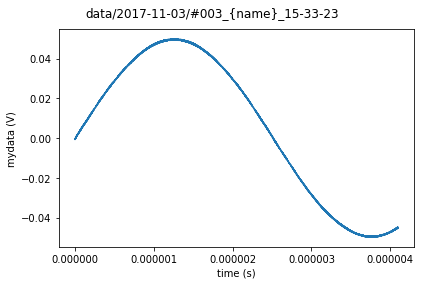

In [13]:
chan1.num_averages(1000)

chan1.alazar_channel('A')
chan1.prepare_channel()

# Measure this 
data1 = qc.Measure(chan1.data).run()
qc.MatPlot(data1.my_controller_mychan_data)

We can measure the time taken to do a measurement

In [14]:
%%time
qc.Measure(chan1.data).run()

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (15.969266 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (15969.265711 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+07 bytes (2.6164e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0015357424480431092
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.004052107914279901
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort too

DataSet:
   location = 'data/2017-11-03/#004_{name}_15-33-24'
   <Type>   | <array_id>                | <array.name> | <array.shape>
   Measured | my_controller_mychan_data | data         | (4096,)
acquired at 2017-11-03 15:33:24
Wall time: 226 ms


DataSet:
   location = 'data/2017-11-03/#004_{name}_15-33-24'
   <Type>   | <array_id>                | <array.name> | <array.shape>
   Measured | my_controller_mychan_data | data         | (4096,)

## Demodulation

We may optionally chose to demodulate the data that we acquire using a software demodulator

In [15]:
chan1d = AlazarChannel(myctrl, 'mychan_demod_1', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (12.159587 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (12159.586797 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+07 bytes (1.99223e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.002284409914047103
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.003913994752601013
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort too

DataSet:
   location = 'data/2017-10-25/#048_{name}_10-56-03'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_mychan_demod_1_data | data         | (4096,)
acquired at 2017-10-25 10:56:03


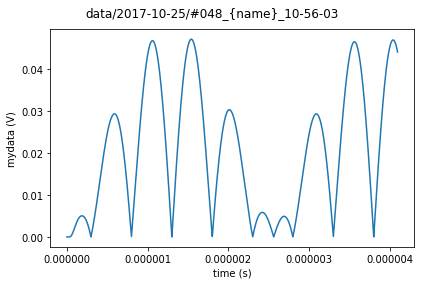

In [16]:
chan1d.num_averages(1000)

chan1d.alazar_channel('A')
chan1d.demod_freq(1e6)
chan1d.demod_type('magnitude')

chan1d.prepare_channel()

# Measure this 
data1d = qc.Measure(chan1d.data).run()
qc.MatPlot(data1d.my_controller_mychan_demod_1_data)

We are free to add more demodulators with different frequencies

In [17]:
chan1d2 = AlazarChannel(myctrl, 'mychan_demod_2', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d2)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (11.295441 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (11295.440844 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+07 bytes (1.85065e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0013169813766324978
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.0042931657434728265
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort t

DataSet:
   location = 'data/2017-10-25/#049_{name}_10-56-04'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_mychan_demod_2_data | data         | (4096,)
acquired at 2017-10-25 10:56:04


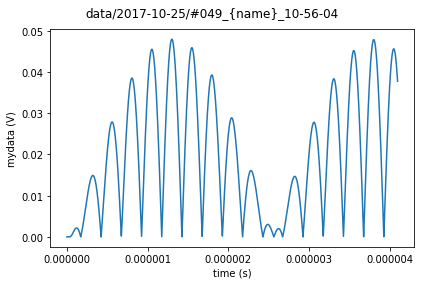

In [18]:
chan1d2.num_averages(1000)

chan1d2.alazar_channel('A')
chan1d2.demod_freq(2e6)
chan1d2.demod_type('magnitude')

chan1d2.prepare_channel()

# Measure this 
data1d = qc.Measure(chan1d2.data).run()
qc.MatPlot(data1d.my_controller_mychan_demod_2_data)

In [19]:
myctrl.channels

ChannelList(<ATS9360Controller: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATS9360Controller: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATS9360Controller: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATS9360Controller: my_controller>])

We can get the data from multiple chanels in one provided that the shape (buffers,records,samples) is the same, The time overhead is fairly small as we are only capturing the data once.

In [20]:
%%time
data = qc.Measure(myctrl.channels.data).run()

c:\users\jens\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (10.871801 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (10871.801493 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+07 bytes (1.78124e+08 bytes per sec)
INFO:qcodes.instrument_drivers.Alazar

DataSet:
   location = 'data/2017-10-25/#050_{name}_10-56-05'
   <Type>   | <array_id>                        | <array.name>                      | <array.shape>
   Setpoint | time_set                          | time                              | (4096,)
   Measured | my_controller_mychan_data         | my_controller_mychan_data         | (4096,)
   Measured | my_controller_mychan_demod_1_data | my_controller_mychan_demod_1_data | (4096,)
   Measured | my_controller_mychan_demod_2_data | my_controller_mychan_demod_2_data | (4096,)
acquired at 2017-10-25 10:56:06
Wall time: 330 ms


c:\users\jens\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (10.402711 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (10402.710750 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+07 bytes (1.70438e+08 bytes per sec)
INFO:qcodes.instrument_drivers.Alazar

DataSet:
   location = 'data/2017-10-25/#051_{name}_10-56-06'
   <Type>   | <array_id>                        | <array.name>                      | <array.shape>
   Setpoint | time_set                          | time                              | (4096,)
   Measured | my_controller_mychan_data         | my_controller_mychan_data         | (4096,)
   Measured | my_controller_mychan_demod_1_data | my_controller_mychan_demod_1_data | (4096,)
   Measured | my_controller_mychan_demod_2_data | my_controller_mychan_demod_2_data | (4096,)
acquired at 2017-10-25 10:56:07


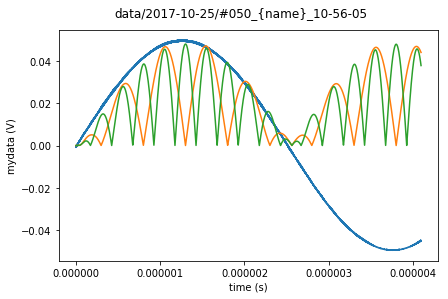

In [21]:
data1 = qc.Measure(myctrl.channels.data).run()
plot = qc.MatPlot()
plot.add(data.my_controller_mychan_data)
plot.add(data.my_controller_mychan_demod_1_data)
plot.add(data.my_controller_mychan_demod_2_data)

# 1D records trace

We can also do a 1D trace of records

In [22]:
chan2 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_records=False)
myctrl.channels.append(chan2)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (798.129233 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 5500 records (43897.107836 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 9.0112e+07 bytes (7.1921e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0022369035718021735
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.08474193059323198
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort

DataSet:
   location = 'data/2017-10-25/#052_{name}_10-56-09'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_data | data         | (55,)
acquired at 2017-10-25 10:56:09


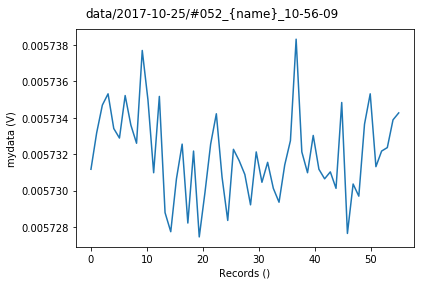

In [23]:
chan2.num_averages(100)
chan2.records_per_buffer(55)
chan2.alazar_channel('A')

chan2.prepare_channel()

# Measure this 
data2 = qc.Measure(myctrl.channels[-1].data).run()
qc.MatPlot(data2.my_controller_myrecchan_data)

Again it is posssible to demodulate the data

In [24]:
chan2d = AlazarChannel(myctrl, 'myrecchan_D', demod=True, average_records=False)
myctrl.channels.append(chan2d)

In [25]:
print(myctrl.int_delay())
print(myctrl.int_time())

2e-07
2e-06


In [26]:
myctrl.int_time._latest

{'raw_value': 2e-06,
 'ts': datetime.datetime(2017, 10, 25, 10, 56, 10, 645745),
 'value': 2e-06}

In [27]:
chan2d.alazar_channel('A')
chan2d.demod_freq(1e6)
chan2d.demod_type('magnitude')

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (744.386331 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 5500 records (40941.248185 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 9.0112e+07 bytes (6.70781e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0020943845450744902
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.09148519195054661
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abor

DataSet:
   location = 'data/2017-10-25/#053_{name}_10-56-12'
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_D_data | data         | (55,)
acquired at 2017-10-25 10:56:12


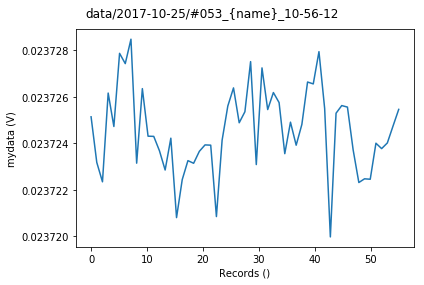

In [28]:
chan2d.num_averages(100)
chan2d.records_per_buffer(55)
chan2d.alazar_channel('A')

chan2d.prepare_channel()

# Measure this 
data2d = qc.Measure(myctrl.channels[-1].data).run()
qc.MatPlot(data2d.my_controller_myrecchan_D_data)

In [29]:
myctrl.channels

ChannelList(<ATS9360Controller: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATS9360Controller: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATS9360Controller: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATS9360Controller: my_controller>, <AlazarChannel: my_controller_myrecchan of ATS9360Controller: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATS9360Controller: my_controller>])

In [30]:
myctrl.channels[-2:]

ChannelList(<ATS9360Controller: my_controller>, AlazarChannel, (<AlazarChannel: my_controller_myrecchan of ATS9360Controller: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATS9360Controller: my_controller>))

c:\users\jens\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (793.327579 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 5500 records (43633.016862 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 9.0112e+07 bytes (7.14883e+08 bytes per sec)
INFO:qcodes.instrument_drivers.A

DataSet:
   location = 'data/2017-10-25/#054_{name}_10-56-13'
   <Type>   | <array_id>                     | <array.name>                   | <array.shape>
   Setpoint | records_set                    | records                        | (55,)
   Measured | my_controller_myrecchan_data   | my_controller_myrecchan_data   | (55,)
   Measured | my_controller_myrecchan_D_data | my_controller_myrecchan_D_data | (55,)
acquired at 2017-10-25 10:56:13


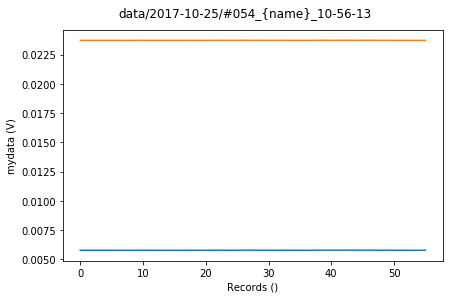

In [31]:
data = qc.Measure(myctrl.channels[-2:].data).run()
plot = qc.MatPlot()
plot.add(data.my_controller_myrecchan_data )
plot.add(data.my_controller_myrecchan_D_data)

# 1D Buffer trace

We can also do a 1D trace over buffers in the same way

In [32]:
chan3 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_buffers=False)
myctrl.channels.append(chan3)


INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (283.733270 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 10000 records (28373.326965 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+08 bytes (4.64869e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.002692319309481661
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.31399228931010015
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abo

DataSet:
   location = 'data/2017-10-25/#055_{name}_10-56-16'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_data | data         | (100,)
acquired at 2017-10-25 10:56:16
10000


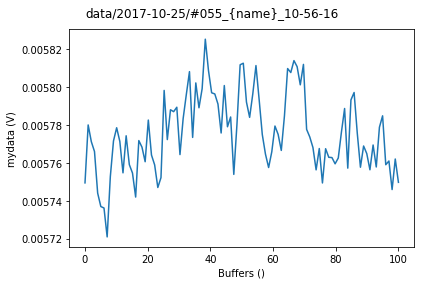

In [33]:
chan3.num_averages(100)
chan3.buffers_per_acquisition(100)
chan3.alazar_channel('A')
alazar.buffer_timeout._set(10000)
alazar.buffer_timeout._set_updated()
chan3.prepare_channel()

# Measure this 
data3 = qc.Measure(chan3.data).run()
qc.MatPlot(data3.my_controller_myrecchan_data)
print(alazar.buffer_timeout())

And demodulate this

In [34]:
chan3d = AlazarChannel(myctrl, 'myrecchan_d', demod=True, average_buffers=False)
myctrl.channels.append(chan3d)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (357.711887 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 10000 records (35771.188743 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+08 bytes (5.86075e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0013322303259926116
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.23545697435625357
INFO:qcodes.instrument_drivers.AlazarTech.ATS:ab

DataSet:
   location = 'data/2017-10-25/#056_{name}_10-56-18'
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_d_data | data         | (100,)
acquired at 2017-10-25 10:56:18
10000


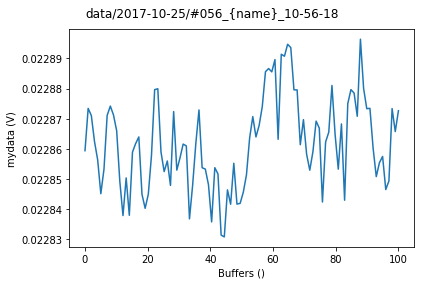

In [35]:
chan3d.num_averages(100)
chan3d.buffers_per_acquisition(100)
chan3d.alazar_channel('A')
chan3d.demod_freq(2e6)
chan3d.demod_type('magnitude')
alazar.buffer_timeout._set(10000)
alazar.buffer_timeout._set_updated()
chan3d.prepare_channel()

# Measure this 
data3 = qc.Measure(chan3d.data).run()
qc.MatPlot(data3.my_controller_myrecchan_d_data)
print(alazar.buffer_timeout())

c:\users\jens\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (382.984929 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 10000 records (38298.492913 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+08 bytes (6.27483e+08 bytes per sec)
INFO:qcodes.instrument_drivers

DataSet:
   location = 'data/2017-10-25/#057_{name}_10-56-58'
   <Type>   | <array_id>                     | <array.name>                   | <array.shape>
   Setpoint | buffers_set                    | buffers                        | (100,)
   Measured | my_controller_myrecchan_data   | my_controller_myrecchan_data   | (100,)
   Measured | my_controller_myrecchan_d_data | my_controller_myrecchan_d_data | (100,)
acquired at 2017-10-25 10:56:59


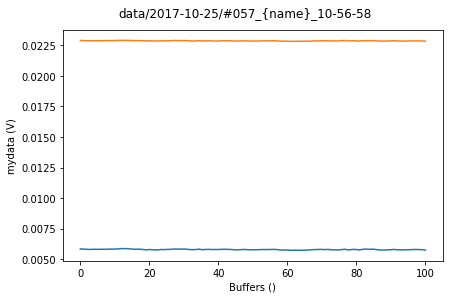

In [36]:
data = qc.Measure(myctrl.channels[-2:].data).run()
plot = qc.MatPlot()
plot.add(data.my_controller_myrecchan_data)
plot.add(data.my_controller_myrecchan_d_data)

# 2D Samples vs records

In [37]:
chan4 = AlazarChannel(myctrl, 'myrecvssamples', demod=False, average_records=False, integrate_samples=False)
myctrl.channels.append(chan4)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (22.001452 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 records (2200.145168 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+06 bytes (3.60472e+07 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0018140384760272354
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 5.219832667080482e-05
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort took

DataSet:
   location = 'data/2017-10-25/#058_{name}_10-57-00'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_myrecvssamples_data | data         | (100, 4096)
acquired at 2017-10-25 10:57:06


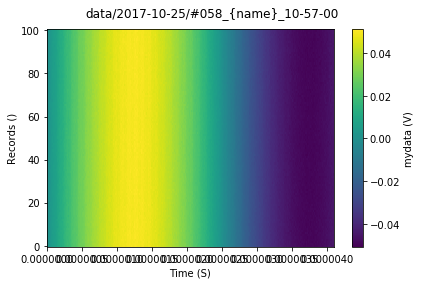

In [38]:
chan4.num_averages(1)
chan4.records_per_buffer(100)
chan4.alazar_channel('A')
chan4.prepare_channel()
# Measure this 
data4 = qc.Measure(chan4.data).run()
qc.MatPlot(data4.my_controller_myrecvssamples_data)

# 2D Buffers vs Records

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 72, 'buffers_per_acquisition': 10, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 10 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 10 buffers (132.088308 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 720 records (9510.358142 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.17965e+07 bytes (1.55818e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0020940912960440983
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.03831063927994194
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort to

DataSet:
   location = 'data/2017-10-25/#059_{name}_10-57-17'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Measured | my_controller_mybuffersvsrecs_data | data         | (10, 72)
acquired at 2017-10-25 10:57:17
10000


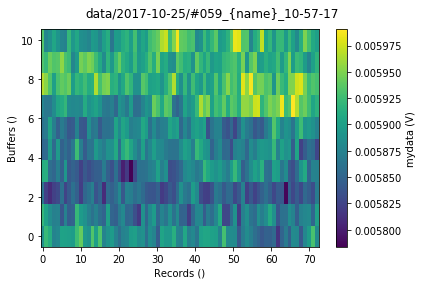

In [39]:
chan5 = AlazarChannel(myctrl, 'mybuffersvsrecs', demod=False, average_records=False, average_buffers=False)
alazar.buffer_timeout._set(10000)
chan5.records_per_buffer(72)
chan5.buffers_per_acquisition(10)
chan5.num_averages(1)
chan5.alazar_channel('A')
chan5.prepare_channel()
# Measure this
data5 = qc.Measure(chan5.data).run()
qc.MatPlot(data5.my_controller_mybuffersvsrecs_data)
print(alazar.buffer_timeout())

# 2D Buffers vs Samples

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 4
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (317.212661 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 10000 records (31721.266108 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+08 bytes (5.19721e+08 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0026767771110911553
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 0.27665113131075714
INFO:qcodes.instrument_drivers.AlazarTech.ATS:ab

DataSet:
   location = 'data/2017-10-25/#060_{name}_10-57-23'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_mybufvssamples_data | data         | (100, 4096)
acquired at 2017-10-25 10:57:30


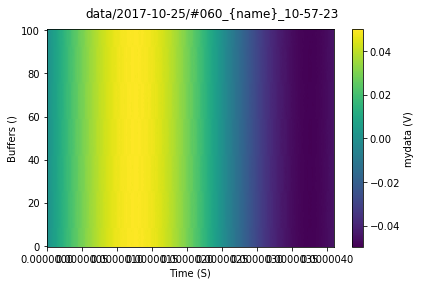

In [40]:
chan6 = AlazarChannel(myctrl, 'mybufvssamples', demod=False, average_buffers=False, integrate_samples=False)
chan6.buffers_per_acquisition(100)
chan6.num_averages(100)
chan6.alazar_channel('A')
chan6.prepare_channel()
# Measure this 
data6 = qc.Measure(chan6.data).run()
plot = qc.MatPlot(data6.my_controller_mybufvssamples_data)


# Single point

In [41]:
chan7 = AlazarChannel(myctrl, 'mybufvssamples', demod=False)


chan7.num_averages(100)
chan7.alazar_channel('A')
chan7.prepare_channel()
# Measure this

data7 = qc.Measure(chan7.data).run()

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (24.299851 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 records (2429.985107 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+06 bytes (3.98129e+07 bytes per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Pre capture setup took 0.0012281269216600776
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capture took 4.310760687076254e-05
INFO:qcodes.instrument_drivers.AlazarTech.ATS:abort took 0.035720370631565856
INFO:qcodes.instrument_drivers.AlazarTech.ATS:handling took 0.00266709989324454
INFO:qcodes.instrument_drivers.AlazarTech.ATS:free mem took 0.0013345763181860093
INFO:qcodes.instrument_drivers.A

DataSet:
   location = 'data/2017-10-25/#061_{name}_11-01-05'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Setpoint | single_set                        | single       | (1,)
   Measured | my_controller_mybufvssamples_data | data         | (1,)
acquired at 2017-10-25 11:01:05


As we are not integrating over samples the setpoints (label, unit and ticks on number) are automatically set from the integration time and integration delay. **Note at the moment this does not cut of the int_delay from the plot. It probably should**

# Multiple channels

In [42]:
chan1 = AlazarChannel(myctrl, 'mychan1', demod=False, integrate_samples=False)
chan1.num_averages(1000)
chan1.alazar_channel('A')
chan1.prepare_channel()
chan2 = AlazarChannel(myctrl, 'mychan2', demod=False, integrate_samples=False)
chan2.num_averages(1000)
chan2.alazar_channel('B')
chan2.prepare_channel()
myctrl.channels.append(chan1)
myctrl.channels.append(chan2)


#plot = qc.MatPlot(data6.my_controller_mybufvssamples_data)

c:\users\jens\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:made buffer list length 1
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (10.196575 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (10196.574501 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.6384e+07 bytes (1.67061e+08 bytes per sec)
INFO:qcodes.instrument_drivers.Alazar

DataSet:
   location = 'data/2017-10-25/#062_{name}_11-01-07'
   <Type>   | <array_id>                 | <array.name>               | <array.shape>
   Setpoint | time_set                   | time                       | (4096,)
   Measured | my_controller_mychan1_data | my_controller_mychan1_data | (4096,)
   Measured | my_controller_mychan2_data | my_controller_mychan2_data | (4096,)
acquired at 2017-10-25 11:01:08


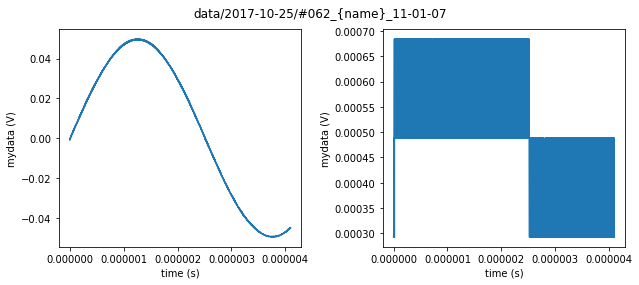

In [43]:
data7 = qc.Measure(myctrl.channels[-2:].data).run()
plot = qc.MatPlot(data7.my_controller_mychan1_data, data7.my_controller_mychan2_data)


### Demodulation

We can add demodulators and remove them again, This will automatically take care of adapting the multiparameter to return multiple arrays to the dataset

In [44]:
myctrl.demod_freqs.add_demodulator(7e6)
myctrl.demod_freqs.add_demodulator(8e6)
myctrl.demod_freqs.add_demodulator(9e6)
myctrl.demod_freqs.add_demodulator(10e6)
myctrl.demod_freqs.add_demodulator(11e6)
myctrl.demod_freqs.add_demodulator(12e6)
myctrl.demod_freqs.add_demodulator(13e6)
print(myctrl.demod_freqs.get())

AttributeError: 'ATS9360Controller' object and its delegates have no attribute 'demod_freqs'

In this example we are demodulating a 10 MHz Signal from the Tektronix AWG

In [13]:
# Do this in as qcodes measurement (ie the same but makes a data set)
data2 = qc.Measure(myctrl.acquisition).run(station=station)


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#060_{name}_15-55-39'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (1664,)
   Measured | my_controller_raw_output         | raw_output         | (1664,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (1664,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (1664,)
   Measured | my_controller_demod_freq_1_mag   | demod_freq_1_mag   | (1664,)
   Measured | my_controller_demod_freq_1_phase | demod_freq_1_phase | (1664,)
   Measured | my_controller_demod_freq_2_mag   | demod_freq_2_mag   | (1664,)
   Measured | my_controller_demod_freq_2_phase | demod_freq_2_phase | (1664,)
   Measured | my_controller_demod_freq_3_mag   | demod_freq_3_mag   | (1664,)
   Measured | my_controller_demod_freq_3_phase | demod_freq_3_phase | (1664,)
   Measured | my_controller_demod_freq_4_mag 

<IPython.core.display.Javascript object>


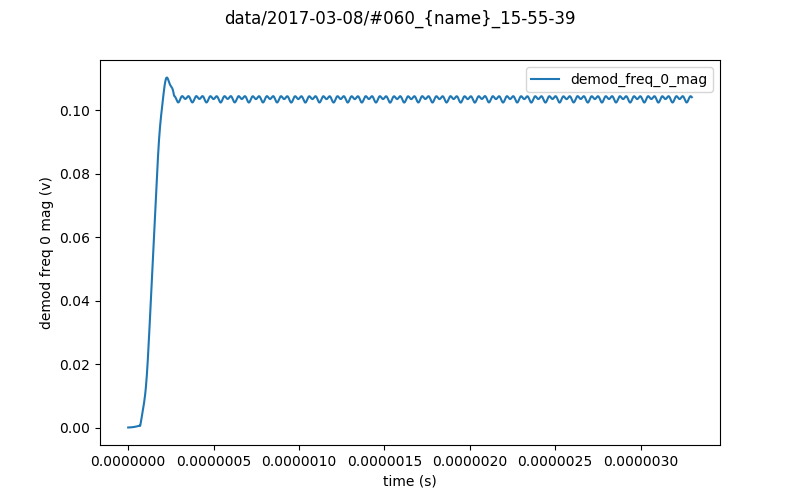

In [47]:
plot = qc.MatPlot()
plot.add(data2.my_controller_demod_freq_0_mag)
plot.fig.axes[0].legend()

<IPython.core.display.Javascript object>


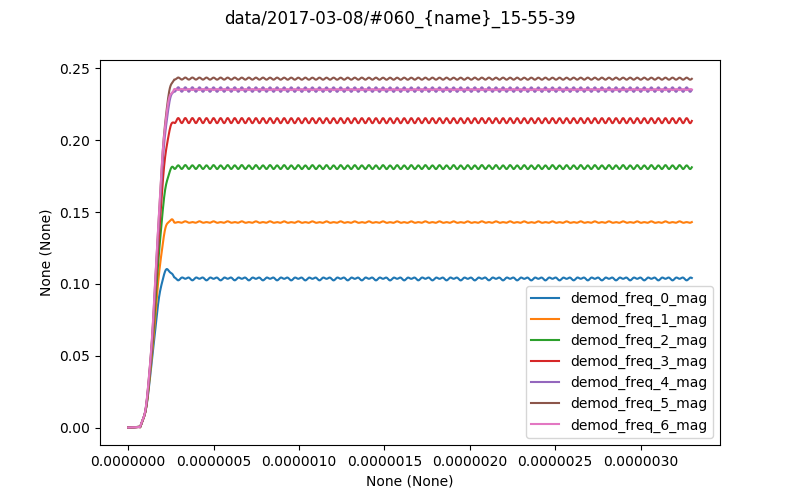

In [14]:
plot = qc.MatPlot(data2.my_controller_demod_freq_0_mag)
plot.add(data2.my_controller_demod_freq_1_mag)
plot.add(data2.my_controller_demod_freq_2_mag)
plot.add(data2.my_controller_demod_freq_3_mag)
plot.add(data2.my_controller_demod_freq_4_mag)
plot.add(data2.my_controller_demod_freq_5_mag)
plot.add(data2.my_controller_demod_freq_6_mag)
plot.fig.axes[0].legend()

There is currently a bug when plotting more than one lineplot the labels are missing

It's possible to change int_time, int_delay and num_avg in an already created acq_controller

In [15]:
myctrl.int_delay(2e-7)
myctrl.int_time(3e-6)
myctrl.num_avg(1)

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-07/#032_{name}_12-36-13'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (3200,)
   Measured | my_controller_raw_output         | raw_output         | (3200,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (3200,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (3200,)
acquired at 2017-03-07 12:36:14


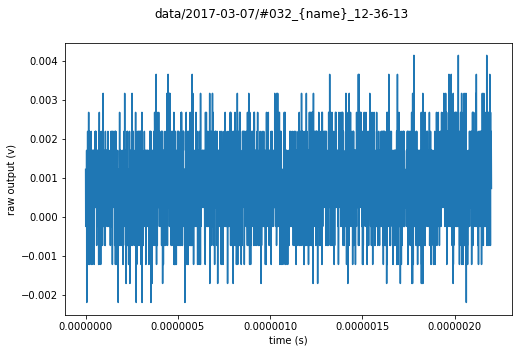

In [16]:
data3 = qc.Measure(myctrl.acquisition).run()
plot = qc.MatPlot(data3.my_controller_raw_output)
plot.fig

Assuming that you have establised the correct int time and delay we can integrate over samples. To change averaging and integrating setting you currently have to create a new controller

## Example 2

We can also chose to not average over records. You currently have to either integrate over samples or average over records (the returned data must be 1D)

In [16]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
myintctrl = ATS9360Controller(name='my_controller_int', alazar_name='Alazar', integrate_samples=True)

In [17]:
myintctrl.int_delay(2e-7)
myintctrl.int_time(3e-6)
myintctrl.num_avg(100)

In [18]:
data4 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#061_{name}_16-00-40'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | single_set                   | single       | (1,)
   Measured | my_controller_int_raw_output | raw_output   | (1,)
acquired at 2017-03-08 16:00:40


We can add the same demodulator freqs and look at the integrated samples 

In [19]:
myintctrl.demod_freqs.add_demodulator(7e6)
myintctrl.demod_freqs.add_demodulator(8e6)
myintctrl.demod_freqs.add_demodulator(9e6)
myintctrl.demod_freqs.add_demodulator(10e6)
myintctrl.demod_freqs.add_demodulator(11e6)
myintctrl.demod_freqs.add_demodulator(12e6)
myintctrl.demod_freqs.add_demodulator(13e6)
print(myintctrl.demod_freqs.get())


[7000000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0]


In [20]:
data5 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#062_{name}_16-00-42'
   <Type>   | <array_id>                           | <array.name>       | <array.shape>
   Setpoint | single_set                           | single             | (1,)
   Measured | my_controller_int_raw_output         | raw_output         | (1,)
   Measured | my_controller_int_demod_freq_0_mag   | demod_freq_0_mag   | (1,)
   Measured | my_controller_int_demod_freq_0_phase | demod_freq_0_phase | (1,)
   Measured | my_controller_int_demod_freq_1_mag   | demod_freq_1_mag   | (1,)
   Measured | my_controller_int_demod_freq_1_phase | demod_freq_1_phase | (1,)
   Measured | my_controller_int_demod_freq_2_mag   | demod_freq_2_mag   | (1,)
   Measured | my_controller_int_demod_freq_2_phase | demod_freq_2_phase | (1,)
   Measured | my_controller_int_demod_freq_3_mag   | demod_freq_3_mag   | (1,)
   Measured | my_controller_int_demod_freq_3_phase | demod_freq_3_phase | (1,)
   Measured | my_controller_int

We can also chose to not average over records. You currently have to either integrate over samples or average over records (the returned data must be 1D)

In [21]:
print(data5.my_controller_int_demod_freq_0_mag)
print(data5.my_controller_int_demod_freq_1_mag)
print(data5.my_controller_int_demod_freq_2_mag)
print(data5.my_controller_int_demod_freq_3_mag)
print(data5.my_controller_int_demod_freq_4_mag)
print(data5.my_controller_int_demod_freq_5_mag)
print(data5.my_controller_int_demod_freq_6_mag)

DataArray[1]: my_controller_int_demod_freq_0_mag
array([ 0.1037831])
DataArray[1]: my_controller_int_demod_freq_1_mag
array([ 0.14285908])
DataArray[1]: my_controller_int_demod_freq_2_mag
array([ 0.18105679])
DataArray[1]: my_controller_int_demod_freq_3_mag
array([ 0.21327569])
DataArray[1]: my_controller_int_demod_freq_4_mag
array([ 0.23483571])
DataArray[1]: my_controller_int_demod_freq_5_mag
array([ 0.24245093])
DataArray[1]: my_controller_int_demod_freq_6_mag
array([ 0.23493526])


As we can see the integrated samples seems consistent with the plots above.

## Example 3

In the last example we are running the AWG in sequencing mode. To do this we need to change the trigger to setup to enable a secondary trigger on the aux input. We change the alazar config here. 

In [48]:
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_TRIGGER_ENABLE', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='TRIG_SLOPE_POSITIVE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

In [24]:
myrecctrl = ATS9360Controller(name='my_controller_rec', alazar_name='Alazar', 
                              integrate_samples=True, average_records=False)

KeyError: 'Another instrument has the name: my_controller_rec'

When not averaging over records averaging is implemented by averaging over buffers and records_per_buffer can be set independently 

In [28]:
myrecctrl.int_delay(2e-7)
myrecctrl.int_time(3e-6)
myrecctrl.num_avg(100)
myrecctrl.records_per_buffer(8)
data6 = qc.Measure(myrecctrl.acquisition).run()


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#065_{name}_16-19-12'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | record_num_set               | record_num   | (8,)
   Measured | my_controller_rec_raw_output | raw_output   | (8,)
acquired at 2017-03-08 16:19:13


Here we are changing the driving freq of the AWG between the freqs below. We demodulate with the same frequencies in 8 records

In [49]:
demod_freqs = [5e6, 7e6, 9e6, 11e6, 13e6, 15e6, 17e6, 19e6]

In [32]:
for freq in demod_freqs:
    myrecctrl.demod_freqs.add_demodulator(freq)

As the setpoints along a records axis is expected to be dependent on an external instrument
which the driver has no way of knowing there is support for setting the base name, unit and start and stop of setpoints (the number of setpoints is automatically set from the number of records) as shown below

In [40]:
myrecctrl.acquisition.set_base_setpoints(base_name='awg_freq', base_label='awg freq', base_unit='Hz',
                             setpoints_start=5e6, setpoints_stop = 19e6)
data6 = qc.Measure(myrecctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#069_{name}_16-29-43'
   <Type>   | <array_id>                           | <array.name>       | <array.shape>
   Setpoint | awg_freq_set                         | awg_freq           | (8,)
   Measured | my_controller_rec_raw_output         | raw_output         | (8,)
   Measured | my_controller_rec_demod_freq_0_mag   | demod_freq_0_mag   | (8,)
   Measured | my_controller_rec_demod_freq_0_phase | demod_freq_0_phase | (8,)
   Measured | my_controller_rec_demod_freq_1_mag   | demod_freq_1_mag   | (8,)
   Measured | my_controller_rec_demod_freq_1_phase | demod_freq_1_phase | (8,)
   Measured | my_controller_rec_demod_freq_2_mag   | demod_freq_2_mag   | (8,)
   Measured | my_controller_rec_demod_freq_2_phase | demod_freq_2_phase | (8,)
   Measured | my_controller_rec_demod_freq_3_mag   | demod_freq_3_mag   | (8,)
   Measured | my_controller_rec_demod_freq_3_phase | demod_freq_3_phase | (8,)
   Measured | my_controller_rec

<IPython.core.display.Javascript object>


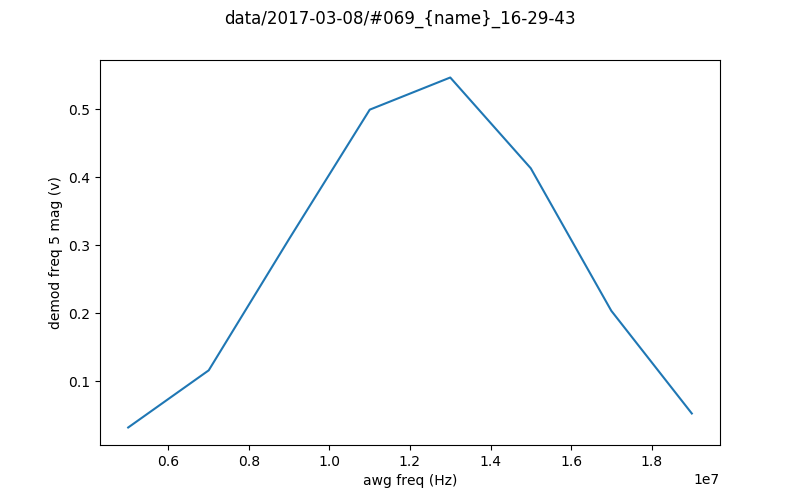

In [51]:
plot = qc.MatPlot(data6.my_controller_rec_demod_freq_5_mag)

<IPython.core.display.Javascript object>


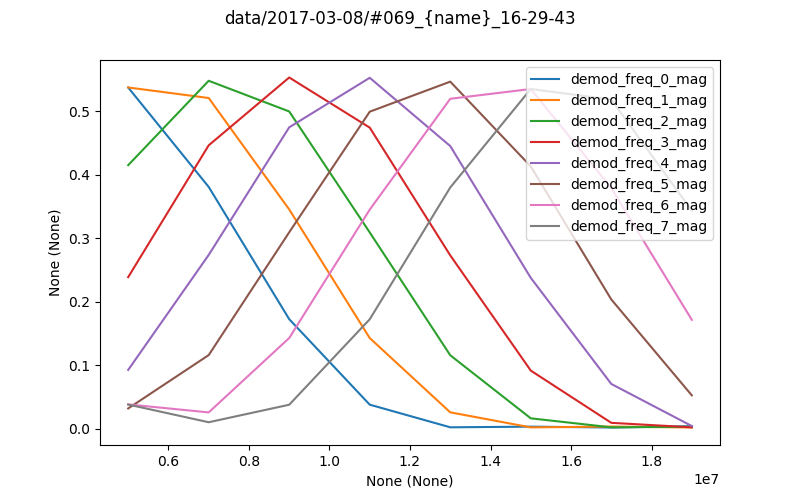

In [50]:
plot = qc.MatPlot(data6.my_controller_rec_demod_freq_0_mag)
plot.add(data6.my_controller_rec_demod_freq_1_mag)
plot.add(data6.my_controller_rec_demod_freq_2_mag)
plot.add(data6.my_controller_rec_demod_freq_3_mag)
plot.add(data6.my_controller_rec_demod_freq_4_mag)
plot.add(data6.my_controller_rec_demod_freq_5_mag)
plot.add(data6.my_controller_rec_demod_freq_6_mag)
plot.add(data6.my_controller_rec_demod_freq_7_mag)
plot.fig.axes[0].legend()

In [16]:
class Demodulator:



    def __init__(self,
                 buffers_per_acquisition: int,
                 records_per_buffer: int,
                 samples_per_record: int,
                 sample_rate: float,
                 filter_settings,
                 active_channels):

        self.filter_settings = filter_settings
        self.active_channels = active_channels
        self.sample_rate = sample_rate
        settings = active_channels[0]
        if settings['average_buffers']:
            len_buffers = 1
        else:
            len_buffers = buffers_per_acquisition

        if settings['average_records']:
            len_records = 1
        else:
            len_records = records_per_buffer

        num_demods = 1
        demod_freqs = np.array(settings['demod_freq'])
        mat_shape = (num_demods, len_buffers,
                     len_records, samples_per_record)
        self.mat_shape = mat_shape
        integer_list = np.arange(samples_per_record)
        integer_mat = (np.outer(np.ones(len_buffers),
                                np.outer(np.ones(len_records), integer_list)))
        angle_mat = 2 * np.pi * \
                    np.outer(demod_freqs, integer_mat).reshape(mat_shape) / sample_rate
        self.cos_mat = np.cos(angle_mat)
        self.sin_mat = np.sin(angle_mat)


    def demodulate(self, volt_rec, int_delay, int_time):
        """
        Applies low bandpass filter and demodulation fit,
        and integration limits to samples array

        Args:
            record (numpy array): record from alazar to be multiplied
                                  with the software signal, filtered and limited
                                  to ifantegration limits shape = (samples_taken, )

        Returns:
            magnitude (numpy array): shape = (demod_length, samples_after_limiting)
            phase (numpy array): shape = (demod_length, samples_after_limiting)
        """

        # volt_rec to matrix and multiply with demodulation signal matrices
        demod_length = 1 #self.demod_freqs.get_num_demods()
        volt_rec_mat = np.outer(np.ones(demod_length), volt_rec).reshape(self.mat_shape)
        re_mat = np.multiply(volt_rec_mat, self.cos_mat)
        im_mat = np.multiply(volt_rec_mat, self.sin_mat)*0

        # filter out higher freq component
        cutoff = self.active_channels[0]['demod_freq']/10
        # self.demod_freqs.get_max_demod_freq() / 10
        if self.filter_settings['filter'] == 0:
            re_filtered = helpers.filter_win(re_mat, cutoff,
                                             self.sample_rate,
                                             self.filter_settings['numtaps'],
                                             axis=-1)
            im_filtered = helpers.filter_win(im_mat, cutoff,
                                             self.sample_rate,
                                             self.filter_settings['numtaps'],
                                             axis=-1)
        elif self.filter_settings['filter'] == 1:
            re_filtered = helpers.filter_ls(re_mat, cutoff,
                                            self.sample_rate,
                                            self.filter_settings['numtaps'],
                                            axis=-1)
            im_filtered = helpers.filter_ls(im_mat, cutoff,
                                            self.sample_rate,
                                            self.filter_settings['numtaps'],
                                            axis=-1)
        elif self.filter_settings['filter'] == 2:
            re_filtered = re_mat
            im_filtered = im_mat
        else:
            raise RuntimeError("Filter setting: {} not implemented".format(self.filter_settings['filter']))

        if self.active_channels[0]['integrate_samples']:
            # apply integration limits
            beginning = int(int_delay * self.sample_rate)
            end = beginning + int(int_time * self.sample_rate)

            re_limited = re_filtered[..., beginning:end]
            im_limited = im_filtered[..., beginning:end]
        else:
            re_limited = re_filtered
            im_limited = im_filtered

        # convert to magnitude and phase
        complex_mat = re_limited + im_limited * 1j
        magnitude = abs(complex_mat)
        phase = np.angle(complex_mat, deg=True)

        
        return magnitude, phase

In [87]:
myctrl.close()
alazar.close()